# RNA-protein correlations

Zoë Steier

* Dataset: SLN111-D1 (mouse spleen and lymph node with 111 protein panel from experiment day 1)
* Calculate totalVI correlations on RNA-protein pairs

## Imports and settings

In [1]:
# Import required packages

import csv
import gzip
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import anndata
import seaborn as sns

from scvi.dataset import GeneExpressionDataset, CellMeasurement, AnnDatasetFromAnnData, CsvDataset
from scvi.models import VAE, TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer, UnsupervisedTrainer

from scipy.special import softmax
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from scipy.stats import spearmanr
from scipy.stats import pearsonr

from scvi import set_seed

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

set_seed(0)

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

In [3]:
# GPU settings

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Load data

In [4]:
# Load anndata

save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

anndataset = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset = anndataset[anndataset.obs["batch_indices"] == 0]

In [5]:
# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset.uns["protein_names"]]
)

anndataset.obsm["protein_expression"] = anndataset.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset.uns["protein_names"] = anndataset.uns["protein_names"][keep_pro_111]
anndataset.obs["cell_types"] = pd.Categorical([ct.replace('\n', '') for ct in  anndataset.obs["cell_types"]])

# Organize and instantiate scVI dataset
hvg_111 = anndataset.var["hvg_encode"]

dataset = AnnDatasetFromAnnData(ad=anndataset[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset.uns["protein_names"]
)
dataset.initialize_cell_measurement(protein_data_111)
dataset.gene_names = anndataset[:, hvg_111].var_names.values

[2020-04-26 12:54:29,502] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-26 12:54:29,508] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-26 12:54:29,586] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-26 12:54:29,648] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells


In [6]:
dataset

GeneExpressionDataset object with n_cells x nb_genes = 9264 x 4005
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'protein_expression', 'local_means', 'batch_indices', 'local_vars', 'labels'
    cell_categorical_attribute_names: 'labels', 'batch_indices'
    cell_measurements_columns: {'protein_expression': 'protein_names'}

## Load and evaluate totalVI model

In [7]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_latent=20,
    #n_batch=dataset.n_batches,
)

In [8]:
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

In [9]:
model.load_state_dict(torch.load("/data/yosef2/users/zsteier/totalVI/totalVI_journal/differential_expression/saved_models/111_d1.pt"))
model.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4115, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [10]:
trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory": False}
)

## Generate model outputs

### Subset the data to exclude doublets before calculating correlations

In [11]:
# Load saved posterior anndata object

adata = anndata.read("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/post_adata_111day1.h5ad")

In [12]:
# Subset clusters before calculating correlations
# Exclude doublets and low quality cells (uncorrelated genes would appear correlated with each other)

include_cells = [
    c not in ["16,0", "17", "19", "21", "23", "24,0", "24,2", "25", "29"]
    for c in anndataset.obs["leiden_subclusters"]
]

In [13]:
# Subset adata to exclude doublets

adata = adata[include_cells]

In [14]:
adata.X.shape

(8736, 4005)

### Create posterior

In [15]:
# create posterior on subset of the data

full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset))[include_cells], type_class=TotalPosterior
)

# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Number of Monte Carlo samples to average over
n_samples = 25

# Probability of background
py_mixing = np.mean(sigmoid(
    full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=False)
), axis=-1)
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=dataset.protein_names
)

# denoised data
denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True,
)

In [16]:
denoised_genes.shape

(8736, 4005)

## Calculate correlations

### Calculate totalVI correlations

In [17]:
# totalVI Pearson

corr_matrix = full_posterior.generate_feature_correlation_matrix(correlation_mode="pearson", 
                                                                  log_transform = True,
                                                                 rna_size_factor = 1e4)

In [18]:
corr_matrix.shape # 4005 genes + 110 proteins

(4115, 4115)

In [19]:
# totalVI Spearman

corr_totalVI_spearman = full_posterior.generate_feature_correlation_matrix(correlation_mode="spearman", 
                                                                  log_transform = True,
                                                                 rna_size_factor = 1e4)

In [20]:
corr_totalVI_spearman.shape # first return is correlation coefficient, second is p value

(2, 4115, 4115)

In [21]:
corr_totalVI_spearmanr = corr_totalVI_spearman[0, :, :]

In [22]:
corr_totalVI_spearmanr.shape

(4115, 4115)

### Calculate raw correlations

In [23]:
# Log-library size normalize RNA by standard pipeline in scanpy

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

Trying to set attribute `.obs` of view, making a copy.


In [24]:
# Log protein

raw_data = np.concatenate((adata.X, np.log1p(adata.obsm["protein_expression"])), axis = 1) # concat genes, proteins

raw_data.shape # cells x (genes + proteins)

(8736, 4115)

In [25]:
# Calculate raw Pearson correlations

corr_raw = np.corrcoef(raw_data, rowvar = False)

In [26]:
corr_raw.shape

(4115, 4115)

In [27]:
# Calculate raw Spearman correlation

corr_raw_spearman =  spearmanr(raw_data, axis = 0)

In [28]:
corr_raw_spearman[0].shape

(4115, 4115)

In [29]:
corr_raw_spearmanr = corr_raw_spearman[0]

## Identify and plot RNA-protein pairs

### Identify RNA-protein pairs

In [30]:
# Find names of all genes and proteins

gene_protein_names = np.concatenate((dataset.gene_names, dataset.protein_names)) # all genes and proteins
gene_protein_names.shape # 4005 RNA + 110 proteins

(4115,)

In [70]:
# Load names of RNA-protein pairs

protein_names = pd.read_csv(
    "/data/yosef2/users/zsteier/totalVI/totalVI_journal/data/metadata/protein_metadata/TotalSeq_ADT206_ADT111_matched.csv"
)
protein_to_rna_table = pd.read_csv(
    "/data/yosef2/users/zsteier/totalVI/totalVI_journal/data/metadata/protein_metadata/TotalSeq_ADT111_barcodes_RNA_20190717.csv"
)

In [72]:
# Subset on proteins included in this panel

subset_111 = protein_names["name_206"][~protein_names["name_111"].isnull()].values

protein_111_names = protein_names["name_111"][~protein_names["name_111"].isnull()].values
RNA_names = []
for p1, p2 in zip(protein_111_names, subset_111):
    ind = np.where(protein_to_rna_table["name"] == p1)[0]    
    RNA_names.append(str(protein_to_rna_table.loc[ind, "RNA"].values[0])) # remove the .upper()
    
rna_protein = pd.concat([pd.Series(RNA_names, name = "RNA_name"), pd.Series(subset_111, name = "protein_name")], axis = 1)

In [73]:
rna_protein

,RNA_name,protein_name
0,Icam2,ADT_CD102_A0104
1,Itgae,ADT_CD103_A0201
2,Vcam1,ADT_CD106_A0226
3,Csf1r,ADT_CD115(CSF-1R)_A0105
4,Kit,ADT_CD117(c-Kit)_A0012
...,...,...
108,Xcr1,ADT_XCR1_A0568
109,P2ry12,ADT_anti-P2RY12_A0415
110,Itgb7,ADT_integrinb7_A0214
111,Ptprc,HTO_B6_LN_r4_206_A0301


In [74]:
# Find indices of gene protein pairs in this dataset

gene_protein_pairs = np.array([gene in np.concatenate((rna_protein["RNA_name"].values, rna_protein["protein_name"].values)) for gene in gene_protein_names])

In [75]:
np.sum(gene_protein_pairs) # 208 = 98 genes + 110 proteins (not unique genes for each protein)
# Be aware that there is a NAN for H-2KbboundtoSIINFEKL

208

In [76]:
# Names of genes/proteins in pairs

rna_prot_pairs_names = gene_protein_names[gene_protein_pairs]

### Subset correlations to RNA-protein pairs

In [77]:
# Subset correlations for RNA-protein pairs

# totalVI pearson
corr_totalvi_rna_prot = corr_matrix[:, gene_protein_pairs]
corr_totalvi_rna_prot = corr_totalvi_rna_prot[gene_protein_pairs, :]

# raw pearson
corr_raw_rna_prot = corr_raw[:, gene_protein_pairs]
corr_raw_rna_prot = corr_raw_rna_prot[gene_protein_pairs, :]

In [78]:
# Subset like above for spearman

# totalVI spearman
corr_totalVI_spearman_rna_prot = corr_totalVI_spearmanr[:, gene_protein_pairs]
corr_totalVI_spearman_rna_prot = corr_totalVI_spearman_rna_prot[gene_protein_pairs, :]

# raw spearman
corr_raw_spearman_rna_prot = corr_raw_spearmanr[:, gene_protein_pairs]
corr_raw_spearman_rna_prot = corr_raw_spearman_rna_prot[gene_protein_pairs, :]

In [79]:
# Create dataframes for raw and totalVI denoised correlations

corr_totalVI_df = pd.DataFrame(corr_totalvi_rna_prot, columns = rna_prot_pairs_names, index = rna_prot_pairs_names)
corr_raw_df = pd.DataFrame(corr_raw_rna_prot, columns = rna_prot_pairs_names, index = rna_prot_pairs_names)

In [80]:
# Subset by protein-RNA pairs (resulting in an array)

protein_names = [protein for protein in rna_protein["protein_name"] if ((rna_protein["RNA_name"][np.where(rna_protein["protein_name"] == protein)[0][0]] != "NAN") & (not protein.startswith("HTO")))]

rna_names = []
for protein in protein_names:
    RNA = rna_protein["RNA_name"][np.where(rna_protein["protein_name"] == protein)[0][0]]
    rna_names.append(RNA)

In [81]:
# Pearson

# Take the subset for totalVI
corr_totalVI_subset = []
corr_rna_names = []
corr_protein_names = []
for i in range(len(rna_names)):
    if rna_names[i] in corr_totalVI_df.index:
        if protein_names[i] in corr_totalVI_df.index:
            corr_totalVI_subset.append(corr_totalVI_df.loc[rna_names[i], protein_names[i]])
            corr_rna_names.append(rna_names[i])
            corr_protein_names.append(protein_names[i])

# Take the subset for raw
corr_raw_subset = []
for i in range(len(rna_names)):
    if rna_names[i] in corr_raw_df.index: 
        if protein_names[i] in corr_totalVI_df.index: 
            corr_raw_subset.append(corr_raw_df.loc[rna_names[i], protein_names[i]])
        
# Collect pairs in dataframe
corr_df = pd.DataFrame(list(zip(corr_rna_names, corr_protein_names, corr_totalVI_subset, corr_raw_subset)), 
                                columns = ["RNA", "Protein", "totalVI_correlation", "raw_correlation"])

In [82]:
# Find which RNA are missing

np.array(rna_names)[[gene not in corr_totalVI_df.index.values for gene in np.array(rna_names)]]
# These RNA were filtered out prior to running totalVI because fewer than four cells expressed them

array(['Pdgfra', 'Fcer1a', 'nan', 'Madcam1', 'Plvap', 'Trbv8', 'Tcrg-v1',
       'Tcrg-V3', 'Ly76'], dtype='<U8')

In [83]:
# Find which proteins are missing

np.array(protein_names)[[protein not in corr_totalVI_df.index.values for protein in np.array(protein_names)]]
# Filtered out before running totalVI

array(['ADT_CD49f_A0070'], dtype='<U35')

In [84]:
# Spearman

# Create dataframes for raw and totalVI denoised 
corr_totalVI_df = pd.DataFrame(corr_totalVI_spearman_rna_prot, columns = rna_prot_pairs_names, index = rna_prot_pairs_names)
corr_raw_df = pd.DataFrame(corr_raw_spearman_rna_prot, columns = rna_prot_pairs_names, index = rna_prot_pairs_names)

# Take the subset for totalVI
corr_totalVI_subset = []
corr_rna_names = []
corr_protein_names = []
for i in range(len(rna_names)):
    if rna_names[i] in corr_totalVI_df.index: 
        if protein_names[i] in corr_totalVI_df.index: 
            corr_totalVI_subset.append(corr_totalVI_df.loc[rna_names[i], protein_names[i]])
            corr_rna_names.append(rna_names[i])
            corr_protein_names.append(protein_names[i])

# Take the subset for raw
corr_raw_subset = []
for i in range(len(rna_names)):
    if rna_names[i] in corr_raw_df.index: 
        if protein_names[i] in corr_totalVI_df.index: 
            corr_raw_subset.append(corr_raw_df.loc[rna_names[i], protein_names[i]])
            
# Collect pairs in dataframe
corr_df_spearman = pd.DataFrame(list(zip(corr_rna_names, corr_protein_names, corr_totalVI_subset, corr_raw_subset)), 
                                columns = ["RNA", "Protein", "totalVI_correlation", "raw_correlation"])

In [85]:
# Which RNA is not unique?

nonunique = []
unique = []
for gene in rna_protein["RNA_name"]:
    if gene in unique:
        nonunique.append(gene)
    else:
        unique.append(gene)

nonunique

['Ptprc', 'Ptprc', 'Ptprc', 'Thy1', 'Ptprc', 'Ptprc']

Explanation: Thy1 encodes CD90.2 here (not CD90.1). Ptprc has four isoforms (remove).

In [86]:
# Remove isoforms

corr_df_spearman_noiso = corr_df_spearman.loc[corr_df_spearman["Protein"] != "ADT_CD90.1(Thy-1.1)_A0380"]
corr_df_spearman_noiso = corr_df_spearman_noiso.loc[corr_df_spearman["RNA"] != "Ptprc"]

corr_df_pearson_noiso = corr_df.loc[corr_df["Protein"] != "ADT_CD90.1(Thy-1.1)_A0380"]
corr_df_pearson_noiso = corr_df_pearson_noiso.loc[corr_df["RNA"] != "Ptprc"]

In [87]:
corr_df_spearman_noiso.shape

(96, 4)

In [88]:
print(corr_df_spearman_noiso.to_string())

          RNA                              Protein  totalVI_correlation  raw_correlation
0       Icam2                      ADT_CD102_A0104             0.198742         0.084558
1       Itgae                      ADT_CD103_A0201             0.534466         0.300348
2       Vcam1                      ADT_CD106_A0226             0.263311         0.169306
3       Csf1r              ADT_CD115(CSF-1R)_A0105             0.284771         0.189167
4         Kit               ADT_CD117(c-Kit)_A0012            -0.142398         0.154067
5       Itgal                      ADT_CD11a_A0595             0.692498         0.359517
6       Itgax                      ADT_CD11c_A0106             0.348007         0.221684
7       Il2rb              ADT_CD122(IL-2Rb)_A0227             0.610273         0.216938
8        Il7r              ADT_CD127(IL-7Ra)_A0198             0.786139         0.485902
9     Tnfrsf4               ADT_CD134(OX-40)_A0195             0.200258         0.160931
10       Flt3        

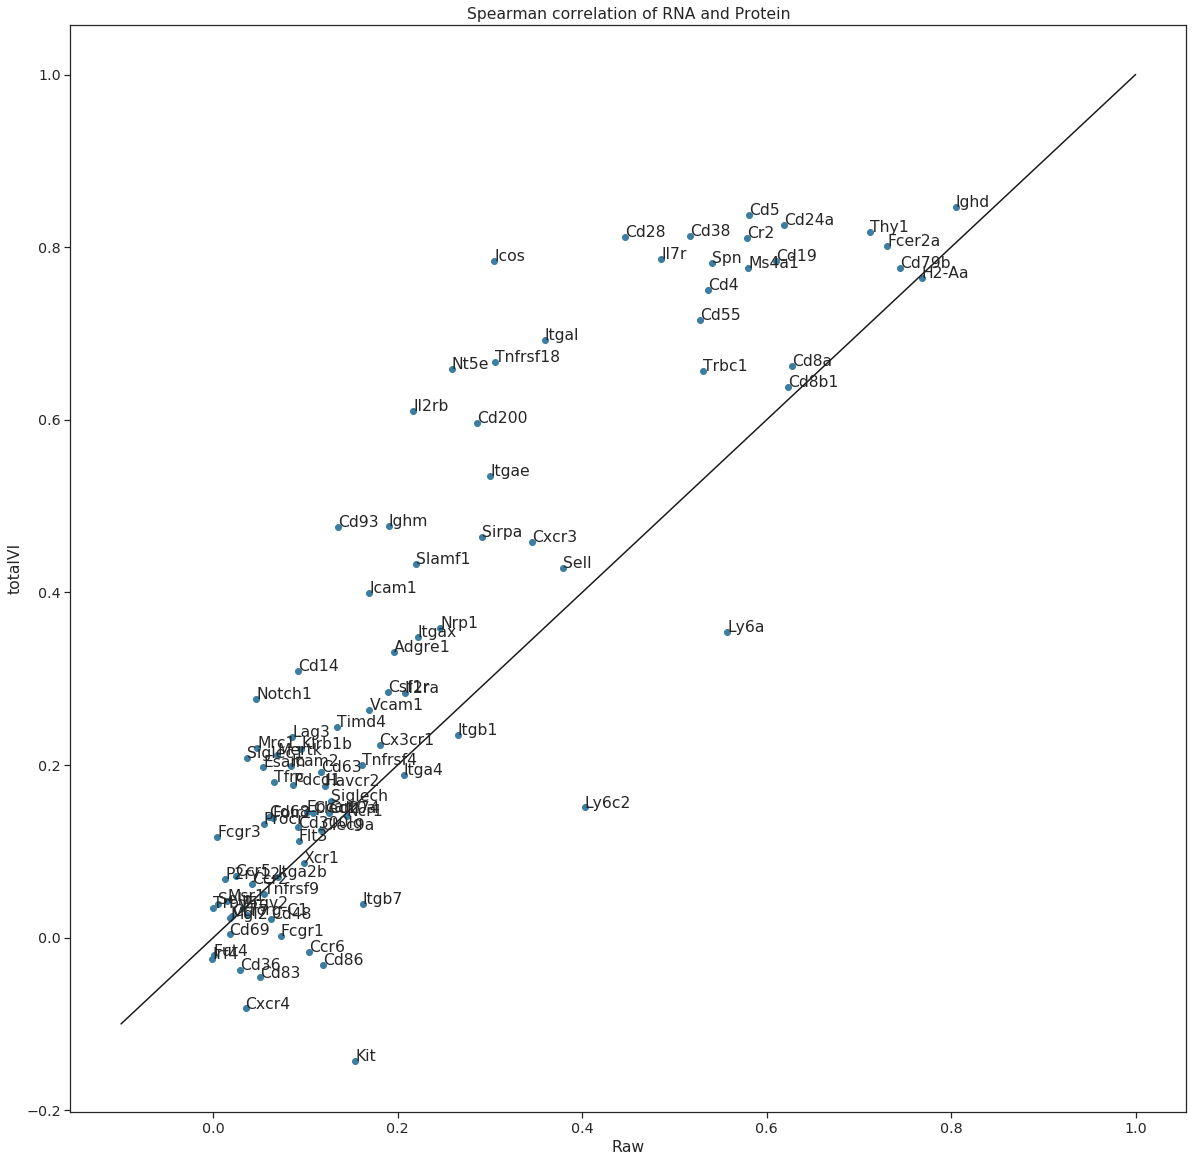

In [89]:
# Plot Spearman correlation
# With RNA names    

plt.figure(figsize = (20, 20))
plt.scatter(x = corr_df_spearman_noiso[["raw_correlation"]], y = corr_df_spearman_noiso[["totalVI_correlation"]])
plt.plot([-.1,1],[-.1,1], "k")
plt.title("Spearman correlation of RNA and Protein")
plt.xlabel("Raw")
plt.ylabel("totalVI")
for x, y, s in zip(corr_df_spearman_noiso[["raw_correlation"]].values, corr_df_spearman_noiso[["totalVI_correlation"]].values, corr_df_spearman_noiso[["RNA"]].values):
    plt.text(x[0], y[0], s[0])

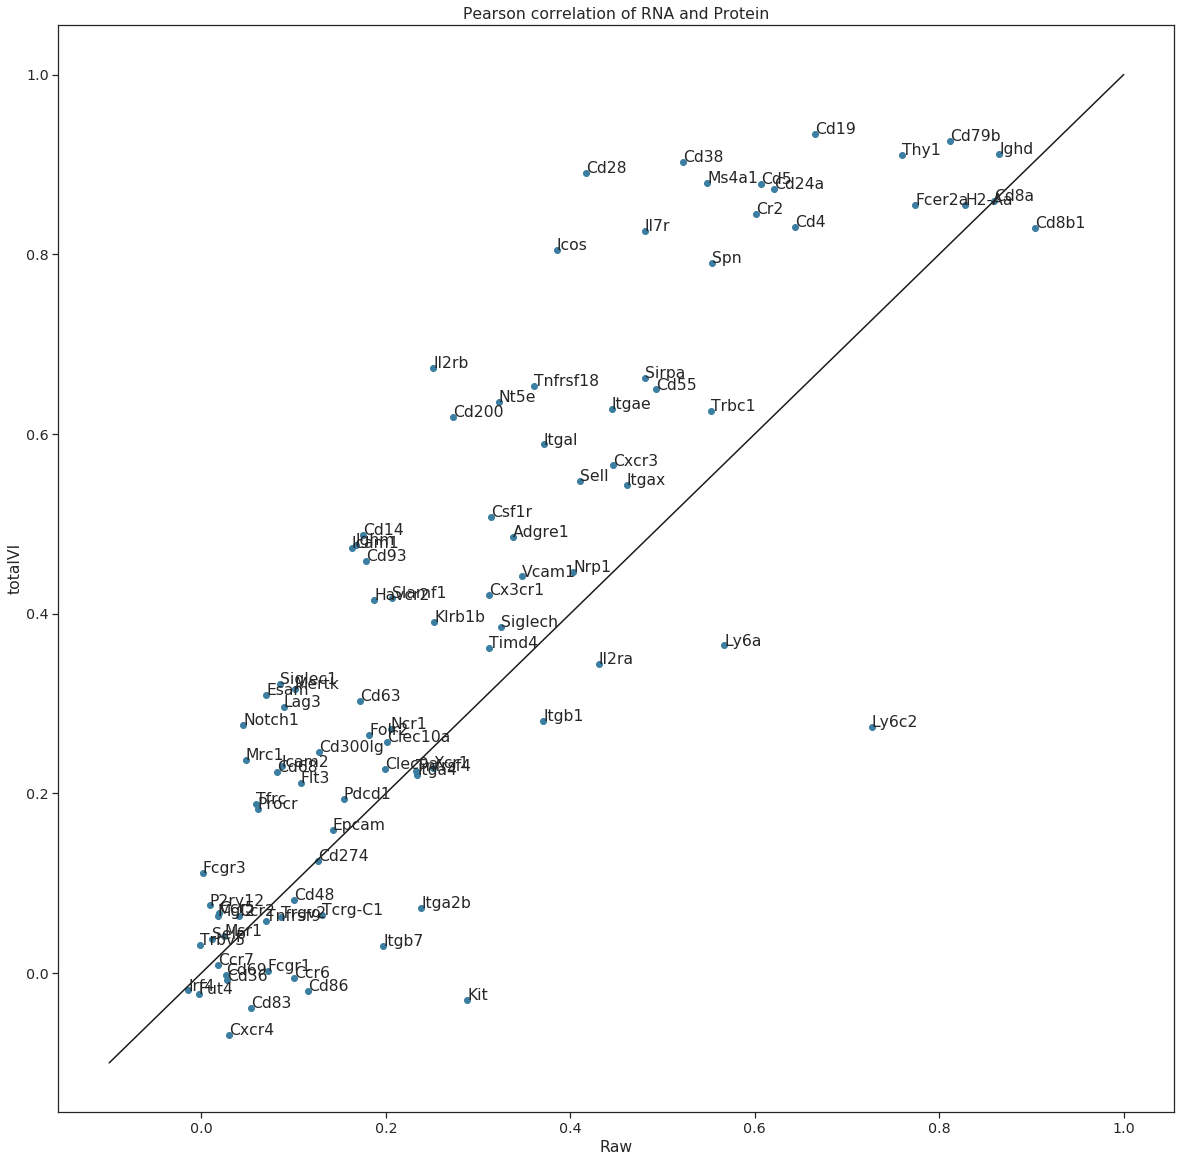

In [90]:
# Plot Pearson
# With RNA names    

plt.figure(figsize = (20, 20))
plt.scatter(x = corr_df_pearson_noiso[["raw_correlation"]], y = corr_df_pearson_noiso[["totalVI_correlation"]])
plt.plot([-.1,1],[-.1,1], "k")
plt.title("Pearson correlation of RNA and Protein")
plt.xlabel("Raw")
plt.ylabel("totalVI")
for x, y, s in zip(corr_df_pearson_noiso[["raw_correlation"]].values, corr_df_pearson_noiso[["totalVI_correlation"]].values, corr_df_pearson_noiso[["RNA"]].values):
    plt.text(x[0], y[0], s[0])

### Plot RNA-protein correlations for totalVI vs raw

In [91]:
# Color each point by raw protein counts, RNA, foreground probability

mean_raw = (np.mean(raw_data, axis = 0))

In [92]:
mean_foreground = np.mean(protein_foreground_prob, axis = 0)

In [93]:
# Extract the mean protein values for the plotted proteins
protein_means = np.asarray([mean_raw[np.where(gene_protein_names == protein)][0] for protein in corr_df_spearman_noiso[["Protein"]].values.ravel()])

In [94]:
# Mean RNA values for the plotted proteins
rna_means = np.asarray([mean_raw[np.where(gene_protein_names == RNA)][0] for RNA in corr_df_spearman_noiso[["RNA"]].values.ravel()])

In [95]:
# Mean foreground probability for the plotted proteins
foreground_means = np.asarray([mean_foreground[np.where(dataset.protein_names == protein)[0][0]] for protein in corr_df_spearman_noiso[["Protein"]].values.ravel()])

In [96]:
len(foreground_means)

96

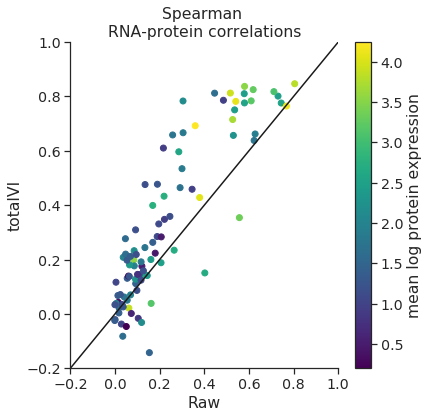

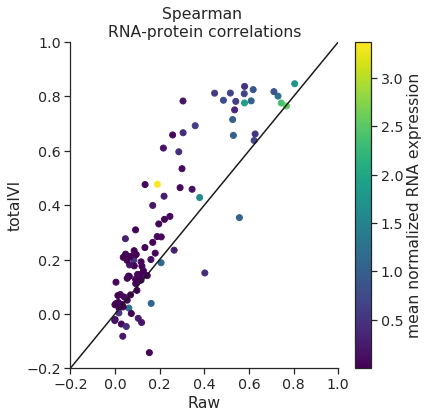

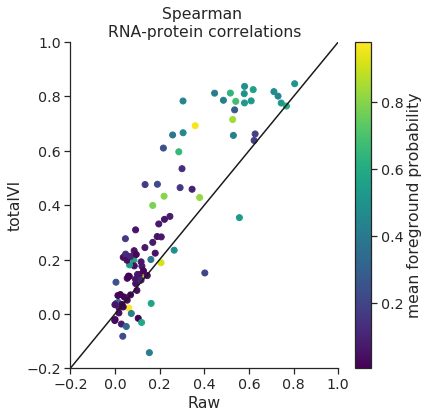

In [128]:
# Plot Spearman correlation
colors_to_plot = [protein_means, rna_means, foreground_means]
labels = ["mean log protein expression", "mean normalized RNA expression", "mean foreground probability"]
filenames = ["protein", "rna", "foreground"]

for i in range(len(colors_to_plot)):
    fig, ax = plt.subplots(figsize=(6, 6)) 
    a = ax.scatter(x = corr_df_spearman_noiso[["raw_correlation"]].values.ravel(), y = corr_df_spearman_noiso[["totalVI_correlation"]].values.ravel(),
               rasterized=True,
               c = colors_to_plot[i],
               cmap = plt.cm.viridis,
               )

    sns.despine()
    plt.plot([-.2,1],[-.2,1], "k")
    plt.title("Spearman \nRNA-protein correlations")
    plt.xlabel("Raw")
    plt.ylabel("totalVI")
    cbar = plt.colorbar(a)
    cbar.set_label(labels[i])
    ax.set_xlim((-.2, 1))
    ax.set_ylim((-.2, 1))

    plt.savefig("figures/spearman_RNAprot_%s_log.pdf" %filenames[i], bbox_inches="tight", dpi = DPI)

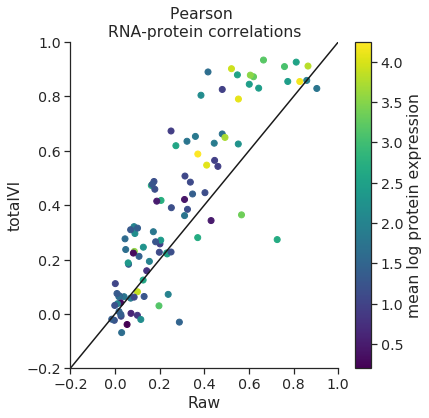

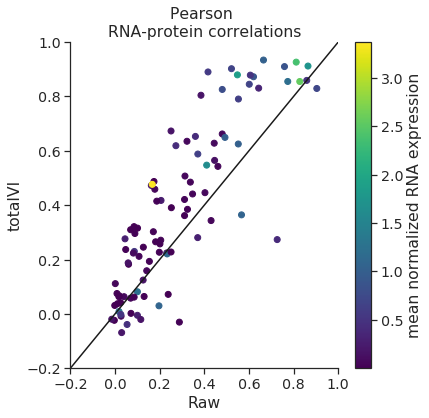

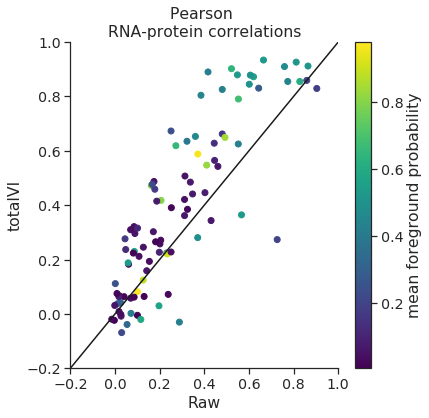

In [129]:
# Plot Pearson correlation
colors_to_plot = [protein_means, rna_means, foreground_means]
labels = ["mean log protein expression", "mean normalized RNA expression", "mean foreground probability"]
filenames = ["protein", "rna", "foreground"]


for i in range(len(colors_to_plot)):
    fig, ax = plt.subplots(figsize=(6, 6))
    a = ax.scatter(x = corr_df_pearson_noiso[["raw_correlation"]].values.ravel(), y = corr_df_pearson_noiso[["totalVI_correlation"]].values.ravel(),
               rasterized=True,
               c = colors_to_plot[i],
               cmap = plt.cm.viridis, 
               )

    sns.despine()
    plt.plot([-.2,1],[-.2,1], "k")
    plt.title("Pearson \nRNA-protein correlations")
    plt.xlabel("Raw")
    plt.ylabel("totalVI")
    cbar = plt.colorbar(a)
    cbar.set_label(labels[i])
    ax.set_xlim((-.2, 1))
    ax.set_ylim((-.2, 1))

    plt.savefig("figures/pearson_RNAprot_%s_log.pdf" %filenames[i], bbox_inches="tight", dpi = DPI)

In [126]:
# Save correlations tables

corr_df_spearman_noiso.to_csv("Spearman_RNA_protein.csv", index = False)
corr_df_pearson_noiso.to_csv("Pearson_RNA_protein.csv", index = False)